In [1]:
import tinyarray as ta
import numpy as np
import matplotlib.pyplot as plt
import importlib
import json
import kwant

from codes.gate_design import gate_coords
from codes.constants import scale, bands, topological_gap, sides
import codes.trijunction as trijunction
import codes.optimization as optimization
import codes.parameters as parameters
from codes.tools import hamiltonian
from codes.utils import eigsh, svd_transformation, dict_update, dep_acc_index
from codes.utils import order_wavefunctions, ratio_Gaussian_curvature

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [2]:
from scipy.optimize import minimize, minimize_scalar

In [3]:
with open('/home/tinkerer/trijunction-design/codes/config.json', 'r') as f:
    config = json.load(f)

change_config = [
    {"device": {"thickness": {"dielectric": 0.5}}},
    {"gate": {"channel_width": 11.0, 'angle': np.pi/6, 'gap': 1}},
]

for local_config in change_config:
    config = dict_update(config, local_config)

In [4]:
system = trijunction.Trijunction(config, optimize_phase_pairs=[])

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


100%|██████████| 13/13 [00:37<00:00,  2.92s/it]


### Initial voltage guess

In [5]:
import codes.gate_design
import importlib
importlib.reload(codes.gate_design)

<module 'codes.gate_design' from '/home/tinkerer/trijunction-design/analysis/codes/gate_design.py'>

In [5]:
kwant_sites = np.array([site.pos for site in system.trijunction.sites])

[[-18.    4.5]
 [-15.5   8.5]
 [-13.   13. ]
 [-10.5  17.5]
 [ -8.   21.5]
 [ -5.5  26. ]
 [ -3.   30.5]
 [ -0.5  34.5]]
[[18.   4.5]
 [15.5  8.5]
 [13.  13. ]
 [10.5 17.5]
 [ 8.  21.5]
 [ 5.5 26. ]
 [ 3.  30.5]
 [ 0.5 34.5]]
[[ 0. 72.]
 [ 0. 67.]
 [ 0. 62.]
 [ 0. 57.]
 [ 0. 52.]
 [ 0. 47.]
 [ 0. 42.]
 [ 0. 37.]]
[[-19.5  24. ]]
[[-5.   8.5]]
[[5.  8.5]]
[[19.5 24. ]]
[[-16.  57.]]
[[16. 57.]]


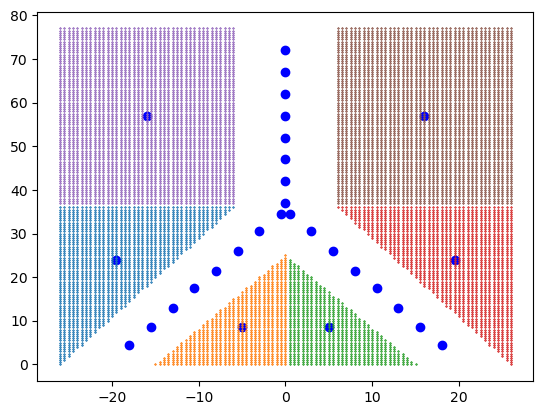

In [275]:
site_coords = system.grid_points[system.site_indices]
for gate, index in system.indices.items():
    point = kwant_sites[index]/scale
    plt.scatter(point[:, 0], point[:, 1], c='b')
    print(point)


for key, value in system.poisson_system.regions.voltage.tag_points.items():
    if not key.startswith(('global', 'dirichlet')):
        coords = system.grid_points[value] 

        plt.scatter(coords[:, 0], coords[:, 1], s = 0.1)

In [ ]:
f_mu = self.f_params(**params)["mu"]

def diff_f_mu(x, y):
    return f_mu(x, y) - f_mu(-x, y)

kwant_sites = np.array(list(site.pos for site in self.trijunction.sites))

to_check = [diff_f_mu(*site) for site in kwant_sites]

#### Optimize potential shape

In [13]:
optimal_voltages = {}
optimal_phase = {}
for pair in ['left-right', 'left-top', 'right-top']:
    
    params = parameters.junction_parameters()
    params.update(potential=system.flat_potential())
    
    index = system.indices.copy()

    # remove 50% of the points from the channel to be depleted that is closest to the center.
    depleted_channel = list(set(sides)-set(pair.split('-')))[0]
    depleted_indices = index[depleted_channel]
    index[depleted_channel]  = depleted_indices[:int(len(depleted_indices)*50/100)]
    
    params['dep_acc_index'] = index
    
    args = (pair.split('-'),
            (system.base_ham, system.linear_terms),
            params['dep_acc_index'], 
            )

    initial_condition = (-3e-3, -3e-3, -3e-3, 3e-3)

    sol1 = minimize(codes.optimization.shape_loss, 
             x0=initial_condition, 
             args=args, 
             method='trust-constr', 
             options={'initial_tr_radius':1e-3}
            )

    print(sol1.x)

    ci, wf_amp = 50, 1e-4
    args = ((system.base_ham, 
            params, 
            system.linear_terms, 
            system.f_params, 
             system.mlwf[order_wavefunctions(pair)]),
            (pair.split('-'), ci, wf_amp)
           )
       
    sol2 = minimize(codes.optimization.wavefunction_loss, 
             x0=sol1.x, 
             args=args, 
             method='trust-constr',
             options={
                 'initial_tr_radius':1e-3,
                 'verbose':2,
             }
            )

    print(sol2.x)

    params.update(parameters.voltage_dict(sol2.x))
    
    args = (pair, 
            params, 
            (system.trijunction, system.linear_terms, 
             system.f_params,
             system.mlwf[order_wavefunctions(pair)]
            )
           )

    sol3 = minimize_scalar(codes.optimization.loss, 
                             args=args, 
                             method='bounded', 
                             bounds=(0,2)
                          )

    
    optimal_phase[pair] = sol3.x * np.pi
    
    print(optimal_phase[pair])

    params.update(parameters.phase_pairs(pair, optimal_phase[pair]))
    
    base_ham = system.trijunction.hamiltonian_submatrix(
        sparse=True, params=system.f_params(**params)
    )

    args = (pair, 
            params, 
            (base_ham, system.linear_terms, 
             system.f_params,
             system.mlwf[order_wavefunctions(pair)]
            ),
           )
    
    file = '/home/tinkerer/trijunction-design/codes/coupling.json'
    with open(file, 'w') as outfile:
        json.dump({}, outfile)

    sol4 = minimize(codes.optimization.loss, 
             x0=sol2.x, 
             args=args, 
             method='trust-constr', 
             options={
                 'initial_tr_radius':1e-3,
                 'verbose':2,
             }
            )
    
    optimal_voltages[pair] = parameters.voltage_dict(sol4.x)
    
    file = '/home/tinkerer/trijunction-design/codes/coupling.json'
    with open(file, 'w') as outfile:
        json.dump({}, outfile)
        
    
    print(optimal_voltages[pair])

[-0.00291775 -0.00292211 -0.00383108  0.00290392]
[-0.00291775 -0.00292211 -0.00383108  0.00290392]
-2.7755735428410703e-05 5.691662011398654e-08 7.172997810031635e-05
[-0.00291777 -0.00292211 -0.00383108  0.00290392]
-2.7755520287149987e-05 5.672121750805155e-08 7.172997216910993e-05
[-0.00291775 -0.00292212 -0.00383108  0.00290392]
-2.77555227890508e-05 5.7110901559086406e-08 7.172997228331175e-05
[-0.00291775 -0.00292211 -0.0038311   0.00290392]
-2.7755728023755824e-05 5.6916600933915285e-08 7.172902264066906e-05
[-0.00291775 -0.00292211 -0.00383108  0.00290393]
-2.775579583887127e-05 5.691677482131302e-08 7.17301305187434e-05
| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | +4.4031e-05 | 1.00e-03 | 6.36e-02 | 0.00e+00 |
[-0.0029044  -0.00253406 -0.0047483   0.00281475]
-3.403579941219165e-05 6.1963339121599135e-06 3.350350669073834e-05
[-0.00290441 -0.00253406 

#### Results

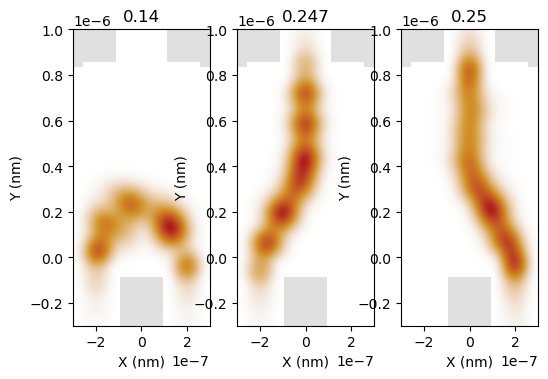

In [17]:
fig, ax = plt.subplots(ncols=3, figsize=(6, 4))

for i, pair in enumerate(['left-right', 'left-top', 'right-top']):
    params = parameters.junction_parameters()
    params.update(potential=system.flat_potential())
    params.update(parameters.phase_pairs(pair, optimal_phase[pair]))
    params.update(optimal_voltages[pair])
    
    base_ham = system.trijunction.hamiltonian_submatrix(
        sparse=True, params=system.f_params(**params)
    )

    linear_ham, full_ham = hamiltonian(base_ham, 
                                       system.linear_terms, 
                                       **params
                                      )

    

    evals, evecs = eigsh(full_ham, k=6, sigma=0, return_eigenvectors=True)

    transformed_hamiltonian = svd_transformation(
        evals, evecs, system.mlwf[order_wavefunctions(pair)]
    )

    desired = np.abs(transformed_hamiltonian[0, 1])
    undesired = np.linalg.norm(transformed_hamiltonian[2:])
    
    wfv = codes.optimization.density(evecs[:, 0])
    
    # potential = linear_ham.diagonal()[::4]
    # step_potential = np.array(np.abs(potential) > bands[0], dtype=int)
    # kwant.plotter.map(system.trijunction, lambda i: step_potential[i], ax=ax[0])
    kwant.plotter.density(system.trijunction, wfv, ax = ax[i]);
    ax[i].set_title(np.round(desired/topological_gap, 3))
    # for value in system.indices.values():
    #     ax[0].scatter(*kwant_sites[value], c='blue')
    
    # voltages = list(optimal_voltages[pair].values())
    # print(pair + ':', np.array(voltages)[list(range(0, 7, 2))])
for axes in ax:
    axes.set_ylim(-3e-7, 10e-7)
    axes.set_xlim(-3e-7, 3e-7)
    axes.set_xlabel('X (nm)')
    axes.set_ylabel('Y (nm)')
    
# fig.tight_layout()
# plt.savefig('/home/tinkerer/trijunction-design/codes/wavefunction.pdf', format='pdf')

#### Shape loss

In [626]:
import codes.optimization
importlib.reload(codes.optimization)

<module 'codes.optimization' from '/home/tinkerer/trijunction-design/analysis/codes/optimization.py'>

In [628]:
pair  = 'left-right'

params = parameters.junction_parameters()
params.update(potential=system.flat_potential())

index = system.indices.copy()

# remove 50% of the points from the channel to be depleted that is closest to the center.
depleted_channel = list(set(sides)-set(pair.split('-')))[0]
depleted_indices = index[depleted_channel]
index[depleted_channel]  = depleted_indices[:int(len(depleted_indices)*50/100)]

params['dep_acc_index'] = index

args = (pair.split('-'),
        (system.base_ham, system.linear_terms),
        params['dep_acc_index'], 
        )

initial_condition = (-3e-3, -3e-3, -3e-3, 3e-3)

sol1 = minimize(codes.optimization.shape_loss, 
         x0=initial_condition, 
         args=args, 
         method='trust-constr', 
         options={'initial_tr_radius':1e-3}
        )

In [629]:
approx_fprime([-3e-3, -3e-3, -3e-3, 3e-3], 
              codes.optimization.shape_loss, 
             1e-8, *args)

array([-6.08047688453187, -5.87166422500608, -1.9084231035862 ,
       -2.13943578756975])

In [575]:
left = np.linspace(sol1.x[0]-1e-2, sol1.x[0]+1e-2, 100)
right = np.linspace(sol1.x[1]-1e-2, sol1.x[1]+1e-2, 100)
left, right = np.meshgrid(left, right)

CPU times: user 611 µs, sys: 1.71 ms, total: 2.33 ms
Wall time: 1.28 ms


In [576]:
%%time

cost = []
for l, r in zip(left.flatten(), right.flatten()):
    x = [l, r, sol1.x[-2], sol1.x[-1]]
    loss = codes.optimization.shape_loss(x, *args)
    cost.append(loss)

CPU times: user 3min 55s, sys: 1.21 s, total: 3min 56s
Wall time: 3min 56s


In [577]:
cost = np.array(cost).reshape(left.shape)

In [578]:
a, b = np.where(cost == cost.min())

In [579]:
zero_points = np.column_stack((left[a, b], right[a, b]))

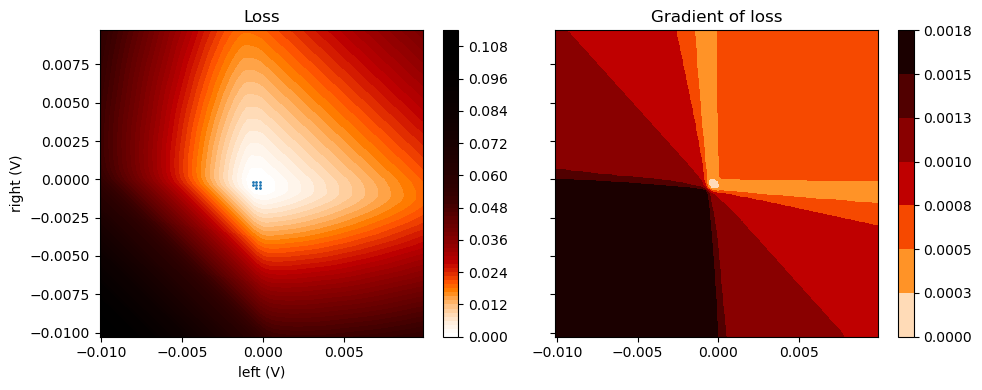

In [625]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
normalizer = HistogramNormalize(cost)
cax = ax[0].contourf(left, right, cost, levels=100,
           norm=normalizer,
             cmap = 'gist_heat_r',
             # vmax = 0.0
          # interpolation="bicubic",
          # extent=(left.min(), left.max(), right.min(), right.max()),
          )

ax[0].scatter(zero_points[:, 0], zero_points[:, 1] , s = 1.0)
plt.colorbar(cax, ax=ax[0])
ax[0].set_xlabel('left (V)')
ax[0].set_ylabel('right (V)')
ax[0].set_title('Loss')

gradient = np.gradient(cost)

fulgrad = np.sqrt(gradient[0]**2 + gradient[1]**2)
cax = ax[1].contourf(left, right, fulgrad, cmap = 'gist_heat_r',
                     # vmin = np.amin(fulgrad),
                     # vmax = np.amax(fulgrad) 
                    )
ax[1].set_title('Gradient of loss')
plt.colorbar(cax, ax=ax[1], format='%.4f')
plt.tight_layout()

#### Wavefunction loss

In [586]:
ci, wf_amp = 50, 1e-4
args = ((system.base_ham, 
        params, 
        system.linear_terms, 
        system.f_params, 
         system.mlwf[order_wavefunctions(pair)]),
        (pair.split('-'), ci, wf_amp)
       )
       

sol2 = minimize(codes.optimization.wavefunction_loss, 
         x0=sol1.x, 
         args=args, 
         method='trust-constr',
         options={
             'initial_tr_radius':1e-3,
             'verbose':2,
         }
        )

[-0.00011074353409 -0.0002740853547  -0.0013505451853   0.00487148892623]


KeyboardInterrupt: 

In [516]:
params = parameters.junction_parameters()
params.update(potential=system.flat_potential())
params['dep_acc_index'] = indices

args = (pair,
        params,
       (system.base_ham, 
        system.linear_terms, 
        system.f_params, 
        system.mlwf[order_wavefunctions(pair)]),
       )


sol2 = minimize(codes.optimization.loss, 
         x0=x0, 
         args=args, 
         method='trust-constr',
         options={'initial_tr_radius':1e-3,
                  'verbose':2,
                 }
        )

NameError: name 'x0' is not defined

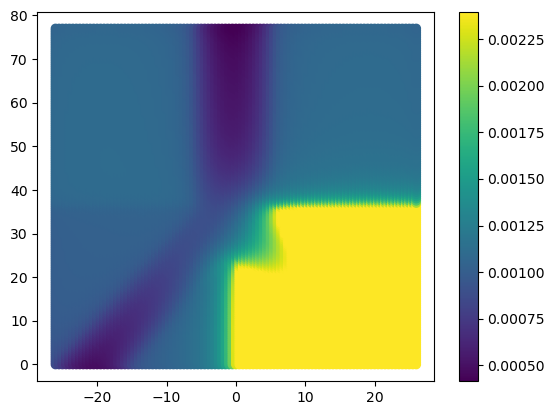

In [357]:
import sys
sys.path.append("/home/tinkerer/spin-qubit/")
from potential import gate_potential

unique_indices = system.site_coords[:, 2] == 0
coords = system.site_coords[unique_indices]
indices = system.site_indices[unique_indices]
voltages = parameters.voltage_dict([-0.00102735,
                                    -0.00413015,
                                    -0.00111647,
                                    0.00354615]),
charges = {}
pot = gate_potential(
    system.poisson_system,
    system.linear_problem,
    coords[:, [0, 1]],
    indices,
    voltages[0],
    {},
    offset=system.offset[[0, 1]],
)

poisson_sites = np.array(list(pot.keys()))

plt.scatter(poisson_sites[:, 0], poisson_sites[:, 1], 
            c = -1*np.array(list(pot.values())), vmax = bands[0])
plt.colorbar();

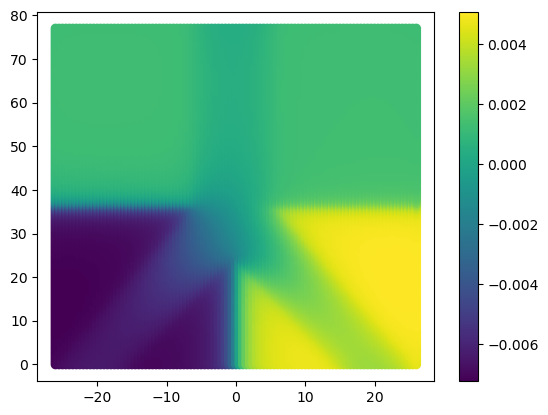

In [514]:
import sys
sys.path.append("/home/tinkerer/spin-qubit/")
from potential import gate_potential

unique_indices = system.site_coords[:, 2] == 0
coords = system.site_coords[unique_indices]
indices = system.site_indices[unique_indices]
voltage = sol1.x.copy()
voltage[0] += +0.0075
voltage[1] += -0.0050
voltages = parameters.voltage_dict(voltage),
charges = {}
pot = gate_potential(
    system.poisson_system,
    system.linear_problem,
    coords[:, [0, 1]],
    indices,
    voltages[0],
    {},
    offset=system.offset[[0, 1]],
)

poisson_sites = np.array(list(pot.keys()))

plt.scatter(poisson_sites[:, 0], poisson_sites[:, 1], 
            c = -1*np.array(list(pot.values())))
plt.colorbar();